# FEC129 Pseudowires with NAPALM
* Also defined in RFC 4447 (like L2circuits)
* RFC 6074
* BGP is used for auto-discovery
* LDP is used to signal the psuedowire
* Like a cross between Kompella and Martini
* Not common in greenfield deployments today
* Also uses Route Target and Route Distinguisher
* Encapsulation and MTU must match
* Encapsulation options similar to Kompella and Martine, i.e. `ethernet-ccc` and `vlan-ccc`

#### Terms
* AGI - Attachment Group Identifier (advertised in a BGP community; look like `l2vpn-id:65501:42`)
* SAII - Source Attachment Individual Identifier (Like a site-ID)
* TAII - Target Attachment Individual Identifier (Like a remote-site-id)
* AGI + SAII + TAII = Unique Identifier for the pseudowire

#### Config commands

Uses `auto-discovery-only` verses `signaling` used in pure Kompella (but the two can both be configured if needed).


##### LDP on loopbacks for targeted LDP sessions:
```
[edit]
set protocols ldp interface lo0.0
```

##### BGP:
```
[edit]
set protocols bgp group INTERNAL type internal
set protocols bgp group INTERNAL local-addresss 1.1.1.1
set protocols bgp group INTERNAL family l2vpn auto-discovery-only
set protocols bgp group INTERNAL neighbor 2.2.2.2
```

##### Routing Instance:
```
[edit routing-instances KICIAKOCIA]
set instance-type l2vpn
set interface ge-0/0/1.0
set interface ge-0/0/2.42
set route-distinguisher 1.1.1.1:12
set l2vpn-id l2vpn-id:64512:45
set vrf-target target:64512:45

[edit routing-instances KICIAKOCIA protocols l2vpn]
set SITE_1 source-attachment-identifier 1
set SITE_1 interface ge-0/0/1.0 target-attachement-identifier 2
set SITE_5 source-attachment-identifier 5
set SITE_5 interface ge-0/0/2.42 target-attachement-identifier 6
```

#### Verify commands
```
show route receive-protocol bgp <router-reflector or peer>
show route receive-protocol bgp <router-reflector or peer> detail
show ldp database
show l2vpn connections
```

#### Topology
* Running IS-IS as the IGP with LDP and MPLS already configured on all core interfaces
* The Cisco router is running VRFs and functions as both CE1 (gig 0/1) and CE2 (gig 0/2)
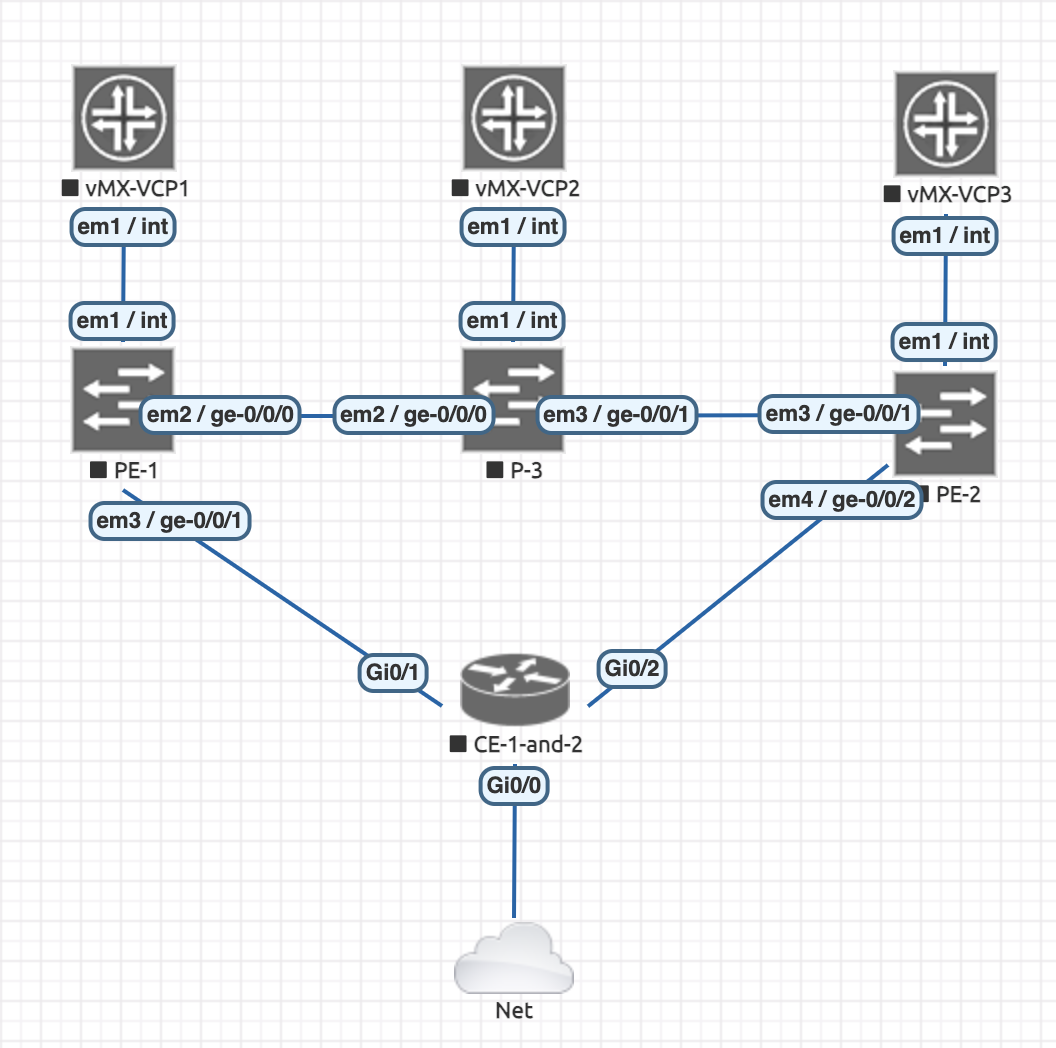

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import configparser
from pprint import pprint
# Load credentials and login info from .ini file
config = configparser.ConfigParser()
config.read("../logins.ini")

devices_login_info = {}
for device in config.sections():
    devices_login_info[device] = {}
    devices_login_info[device]["hostname"] = config[device]["host"]
    devices_login_info[device]["username"] = config[device]["username"]
    devices_login_info[device]["password"] = config[device]["password"]

loopback_pe1 = "1.1.1.1"
loopback_pe2 = "2.2.2.2"

In [3]:
from napalm import get_network_driver

driver = get_network_driver("junos")

for device, login_info in devices_login_info.items():
    try:
        # Probably not the best practice to use globals() here,
        # but makes names convinent for on-the-fly testing
        globals()[device] = driver(**login_info)
        globals()[device].open()
        print(f"Creating Napalm connection for {device}")
    except:
        print(f"Error connecting to {device}.")

Creating Napalm connection for PE1
Creating Napalm connection for P
Creating Napalm connection for PE2


In [4]:
def backup_to_file(device, file_name):
    backup_config = device.get_config()
    running_config = backup_config["running"]
    with open(file_name, "w") as file:
        file.write(running_config)
    print(f"Configuration backup saved to {file_name}!")

def load_from_backup(device, file_name):
    device.load_replace_candidate(filename=file_name)
    diff = device.compare_config()
    if diff:
        print("Configuration changes detected:\n", diff)
        device.commit_config()
        print("Backup successfully restored!")
    else:
        print("No changes detected, backup already matches.")

In [8]:
#output = PE1.get_config(sanitized=True, format="text")
#print(output['running'])

In [5]:
#backup_to_file(PE1, "PE1_napalmlab_backup.txt")
#backup_to_file(PE2, "PE2_napalmlab_backup.txt")

In [6]:
load_from_backup(PE1, "PE1_napalmlab_backup.txt")
load_from_backup(PE2, "PE2_napalmlab_backup.txt")

No changes detected, backup already matches.
No changes detected, backup already matches.


## LDP Targeted sessions
* Configure LDP on the loopbacks for targeted sessions

In [7]:
targeted_ldp_commands = "set protocols ldp interface lo0.0"
PE1.load_merge_candidate(config=targeted_ldp_commands)
print("Changes on PE1:\n", PE1.compare_config())
PE1.commit_config()
PE2.load_merge_candidate(config=targeted_ldp_commands)
print("Changes on PE2:\n", PE2.compare_config())
PE2.commit_config()
print("Changes commited")

Changes on PE1:
 [edit protocols ldp]
+    interface lo0.0;
Changes on PE2:
 [edit protocols ldp]
+    interface lo0.0;
Changes commited


## BGP for FEC129
* Configure internal BGP peers between PE loopbacks with `family l2vpn auto-discovery-only`

In [8]:
bgp_config = """set protocols bgp group INTERNAL type internal
set protocols bgp group INTERNAL local-address {local_ip}
set protocols bgp group INTERNAL family l2vpn auto-discovery-only
set protocols bgp group INTERNAL neighbor {peer_ip}"""

PE1.load_merge_candidate(config=bgp_config.format(local_ip=loopback_pe1, peer_ip=loopback_pe2))
print("Changes on PE1:\n", PE1.compare_config())
PE1.commit_config()
PE2.load_merge_candidate(config=bgp_config.format(local_ip=loopback_pe2, peer_ip=loopback_pe1))
print("Changes on PE2:\n", PE2.compare_config())
PE2.commit_config()
print("BGP changes commited")

Changes on PE1:
 [edit protocols]
+   bgp {
+       group INTERNAL {
+           type internal;
+           local-address 1.1.1.1;
+           family l2vpn {
+               auto-discovery-only;
+           }
+           neighbor 2.2.2.2;
+       }
+   }
Changes on PE2:
 [edit protocols]
+   bgp {
+       group INTERNAL {
+           type internal;
+           local-address 2.2.2.2;
+           family l2vpn {
+               auto-discovery-only;
+           }
+           neighbor 1.1.1.1;
+       }
+   }
BGP changes commited


## CE Facing Interface
* This example only uses Ethernet mode, but Ethernet-VLAN mode is also possible

In [10]:
pe_to_ce_interface_config = """
delete interfaces {interface}
set interfaces {interface} encapsulation ethernet-ccc
set interfaces {interface} unit 0
"""

In [11]:
PE1.load_merge_candidate(config=pe_to_ce_interface_config.format(interface="ge-0/0/1"))
print("Changes on PE1:\n", PE1.compare_config())
PE1.commit_config()
PE2.load_merge_candidate(config=pe_to_ce_interface_config.format(interface="ge-0/0/2"))
print("Changes on PE2:\n", PE2.compare_config())
PE2.commit_config()
print("Interfaces updated to Type 5 Ethernet mode with changes commited")

Changes on PE1:
 [edit interfaces ge-0/0/1]
-   description TO-CE1;
+   encapsulation ethernet-ccc;
+   unit 0;
Changes on PE2:
 [edit interfaces ge-0/0/2]
-   description TO-CE2;
+   encapsulation ethernet-ccc;
+   unit 0;
Interfaces updated to Type 5 Ethernet mode with changes commited


## Routing Instance for FEC129

In [12]:
fec129_routing_instance_config = """ set routing-instances FEC129 instance-type l2vpn
set routing-instances FEC129 interface {interface}.0
set routing-instances FEC129 route-distinguisher {loopback_ip}:12
set routing-instances FEC129 l2vpn-id l2vpn-id:64512:45
set routing-instances FEC129 vrf-target target:64512:45
set routing-instances FEC129 protocols l2vpn site SITE_{saii} source-attachment-identifier {saii}
set routing-instances FEC129 protocols l2vpn site SITE_{saii} interface {interface}.0 target-attachment-identifier {taii}
"""

In [14]:
PE1.load_merge_candidate(config=fec129_routing_instance_config.format(interface='ge-0/0/1', loopback_ip=loopback_pe1, saii=1, taii=2))
print("Changes on PE1:\n", PE1.compare_config())
PE1.commit_config()
PE2.load_merge_candidate(config=fec129_routing_instance_config.format(interface='ge-0/0/2', loopback_ip=loopback_pe2, saii=2, taii=1))
print("Changes on PE2:\n", PE2.compare_config())
PE2.commit_config()
print("BGP changes commited")

Changes on PE1:
 [edit]
+  routing-instances {
+      FEC129 {
+          instance-type l2vpn;
+          interface ge-0/0/1.0;
+          route-distinguisher 1.1.1.1:12;
+          l2vpn-id l2vpn-id:64512:45;
+          vrf-target target:64512:45;
+          protocols {
+              l2vpn {
+                  site SITE_1 {
+                      source-attachment-identifier 1;
+                      interface ge-0/0/1.0 {
+                          target-attachment-identifier 2;
+                      }
+                  }
+              }
+          }
+      }
+  }
Changes on PE2:
 [edit]
+  routing-instances {
+      FEC129 {
+          instance-type l2vpn;
+          interface ge-0/0/2.0;
+          route-distinguisher 2.2.2.2:12;
+          l2vpn-id l2vpn-id:64512:45;
+          vrf-target target:64512:45;
+          protocols {
+              l2vpn {
+                  site SITE_2 {
+                      source-attachment-identifier 2;
+                      interface ge-0/0

## Verify
* TODO: add verification commands (checked and tested directly on router for now)

## Reload initial config
* Remove the FEC129 config and return lab to original state

In [15]:
load_from_backup(PE1, "PE1_napalmlab_backup.txt")
load_from_backup(PE2, "PE2_napalmlab_backup.txt")

Configuration changes detected:
 [edit interfaces ge-0/0/1]
+   description TO-CE1;
-   encapsulation ethernet-ccc;
-   unit 0;
[edit protocols]
-   bgp {
-       group INTERNAL {
-           type internal;
-           local-address 1.1.1.1;
-           family l2vpn {
-               auto-discovery-only;
-           }
-           neighbor 2.2.2.2;
-       }
-   }
[edit protocols ldp]
-    interface lo0.0;
[edit]
-  routing-instances {
-      FEC129 {
-          instance-type l2vpn;
-          interface ge-0/0/1.0;
-          route-distinguisher 1.1.1.1:12;
-          l2vpn-id l2vpn-id:64512:45;
-          vrf-target target:64512:45;
-          protocols {
-              l2vpn {
-                  site SITE_1 {
-                      source-attachment-identifier 1;
-                      interface ge-0/0/1.0 {
-                          target-attachment-identifier 2;
-                      }
-                  }
-              }
-          }
-      }
-  }
Backup successfully restored!
